In [120]:
import numpy as np
import pandas as pd
pd.set_option("precision", 3)
import matplotlib.pyplot as plt
from funcs.fitting import loss_single_seg
from datetime import datetime

In [121]:
df = pd.read_csv('data/stoke_delta_t.csv', comment='#')
df = df.dropna() 
df['time'] = pd.to_datetime(df['time'])
df['timestamp'] = df['time'].values.astype(np.int64)//10**9 # Add a timestamp column, measured in seconds
cols = ['outside','1N','2N','3N','4N','BMS'] # select a subset of columns
df['gas'] *= 1000/(3600) # convert kW*h to W*s (factor of 2 for 1/2 hour?)
df.describe()

,outside,1N,1S,2N,2S,3N,3S,4N,4S,BMS,gas,timestamp
count,3336.000,3336.00,3336.000,3336.000,3336.000,3336.000,3336.000,3336.000,3336.000,3336.000,3336.000,3.336e+03
mean,6.143,18.75,20.830,21.625,22.438,21.521,21.609,21.072,20.984,21.109,22.539,1.584e+09
std,2.190,1.14,1.001,0.772,0.892,0.926,0.835,0.972,0.943,0.750,8.640,8.193e+06
min,-0.100,16.70,17.100,20.000,20.000,19.800,19.900,17.500,17.500,19.100,0.000,1.577e+09
25%,4.700,17.80,20.100,21.200,21.800,21.000,21.100,20.300,20.200,20.500,18.889,1.579e+09
50%,6.300,18.80,20.700,21.700,22.400,21.600,21.600,21.100,20.900,21.100,21.944,1.581e+09
75%,7.600,19.50,21.400,22.200,23.100,22.200,22.200,21.800,21.700,21.625,26.944,1.586e+09
max,11.400,22.50,24.100,23.600,24.800,23.800,24.000,23.700,23.600,23.400,71.944,1.607e+09


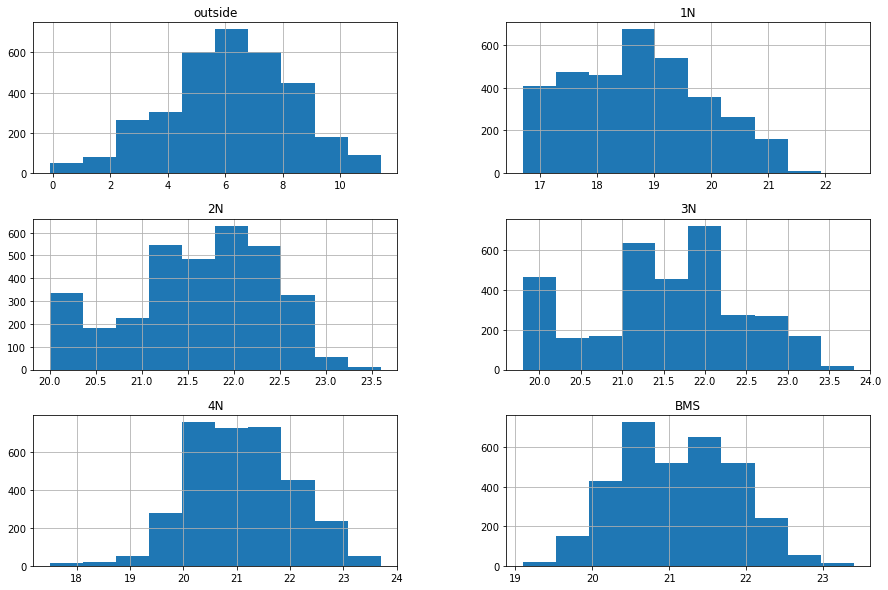

In [122]:
fig, ax = plt.subplots(3,2, figsize=(15,10))
df.hist(cols, ax=ax.ravel());

#### Below is all temperature readings stacked, between 2019-12-19 and 2019-12-30

In [6]:
# define two time ranges to plot over
fmt = '%Y-%m-%dT%H:%M:%S.%f'
xlim1 = [datetime.strptime(time, fmt) for time in ['2020-02-13T00:00:00.00','2020-02-15T00:00:00.00']]
xlim2 = [datetime.strptime(time, fmt) for time in ['2019-12-19T00:00:00.00','2019-12-30T00:00:00.00']]

[Text(0, 0.5, 'Temperature (C)'), (18305.0, 18307.0)]

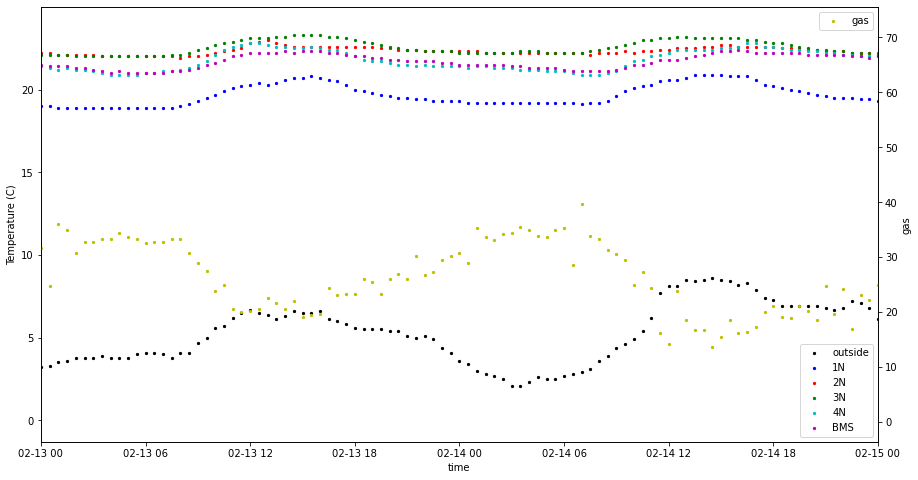

In [7]:
fig, ax = plt.subplots(1,1, figsize=(15,8))
colors = 'kbrgcm'
for i, col in enumerate(cols):
    df.plot(x='time', y=col, kind='scatter', s=5, ax=ax, label=col, color=colors[i])
ax2 = ax.twinx()
df.plot(x='time', y='gas', kind='scatter', s=5, ax=ax2, color='y', label='gas')
ax.set(ylabel = 'Temperature (C)', xlim=xlim1) 
# ax.legend()

#### Below is all temperature readings separated, between 2019-12-19 and 2019-12-30

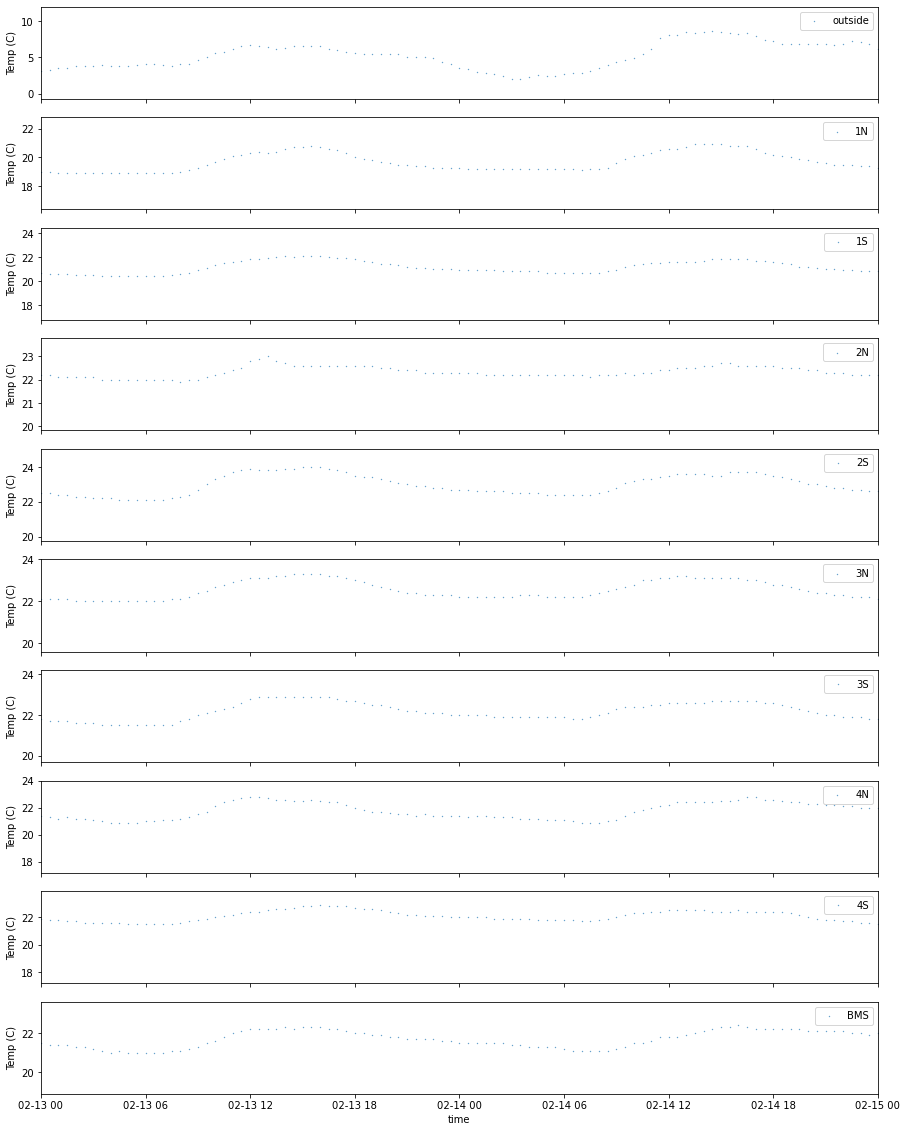

In [8]:
fig, axes = plt.subplots(10,1, figsize=(15,20), sharex=True)
for ax, col in zip(axes,df.columns[1:]):
    df.plot(x='time', y=col, kind='scatter', s=0.1, ax=ax, xlim=xlim1, label=col)
    ax.set(ylabel = 'Temp (C)') 

# Fitting real data

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from funcs.models import model_ND
from funcs.fitting import loss
from scipy.optimize import minimize

## 1 Segment

In [171]:
T_out = 10
iterations = 100

# Run simulation. This recreates simple_model.ipynb showing that our generalised model works.
times, Ts_true, Q_in, T_out = df[['timestamp','1N','gas','outside']].head(1000).values.T
times = (times-times[0])

In [172]:
# Initial guesses for scipy.optimize.minimize
k0 = 1000.0
c0 = 7e6
T0 = 18.9
initial_params = np.array([k0, c0, T0])

In [173]:
np.diff(times)[0]

1800.0

In [174]:
error, Ts = loss_single_seg(initial_params, 'mse', times, Ts_true, T_out, Q_in)

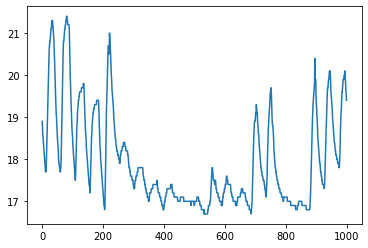

In [175]:
plt.plot(Ts_true)

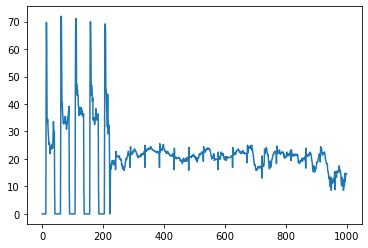

In [176]:
plt.plot(Q_in)

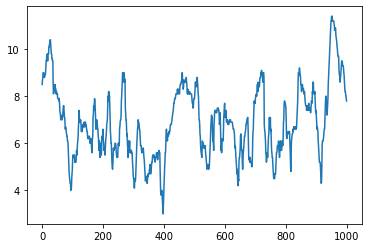

In [177]:
plt.plot(T_out)

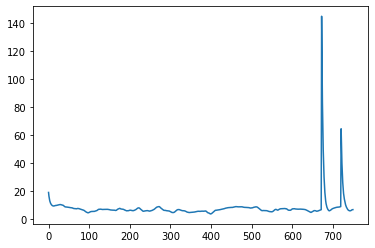

In [178]:
plt.plot(Ts[:750])

In [179]:
# result = minimize(loss_single_seg, x0=initial_params, tol=1e-3, args=('mse', times, Ts_true, T_out, Q_in), bounds=((1e2,1e3),(1e5,1e6),(10,30)))
# # k_est, c_est, T_est = result['x'].reshape((3,2))

In [180]:
# sys_est = model_ND('Estimated',k_est, c_est, T_est, T_out, heatinput)
# Ts_est, Qs = sys_est.run(times=times, func_Q_in=func_Q_in)

# fig, ax = sys_nd.plot(ls='--')
# fig, ax= sys_est.plot(figax=(fig, ax), show_heating=False)

# frac_error = abs((result['x'] - true_params)/true_params * 100)
# print('\tInitial\t\t\tEstimated\t\tActual\nk1:\t{:.5f}\t\t{:.5f}\t\t{:.5f}\nk2:\t{:.5f}\t\t{:.5f}\t\t{:.5f}\nc1:\t{:.5f}\t\t{:.5f}\t\t{:.5f}\nc2:\t{:.5f}\t\t{:.5f}\t\t{:.5f}\nT1:\t{:.5f}\t\t{:.5f}\t\t{:.5f}\nT2:\t{:.5f}\t\t{:.5f}\t\t{:.5f}'.format(*np.ravel([initial_params,result['x'],true_params],'F')))
# print('_'*54)
# print('Percentage error:\nk1:\t\t{:.2f}%\t\tk2:\t\t{:.2f}%\nc1:\t\t{:.2f}%\t\tc2:\t\t{:.2f}%\nT1_initial:\t{:.2f}%\t\tT2_initial:\t{:.2f}%'.format(*frac_error))

NameError: name 'k_est' is not defined